### Imports and Initialization

In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import random
from scipy import signal
from torchvision import transforms
torch.manual_seed(124)
random.seed(124)
np.random.seed(124)

# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
#Loading Training Data
train_data = pd.read_csv('mitbih_train.csv')

In [9]:
#Assign class names using dictionary
#Data Source: Physionet's MIT-BIH Arrhythmia Dataset
#Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
class_names = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}

### Data Visualization

In [3]:
#Preview Training Data
row_no, col_no = train_data.shape
print(f'There are {row_no} rows and {col_no} columns')

There are 87553 rows and 188 columns


In [4]:
#Targets
y_df = train_data.iloc[:, -1]
y_df.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 0.000000000000000000e+00.88, dtype: float64

In [5]:
#Convert to Int
y_df = y_df.astype('int')
y_df.head()

0    0
1    0
2    0
3    0
4    0
Name: 0.000000000000000000e+00.88, dtype: int32

In [6]:
#Features
X_df = train_data.iloc[:, :-1]
X_df.head()

,9.779411554336547852e-01,9.264705777168273926e-01,6.813725233078002930e-01,2.450980395078659058e-01,1.544117629528045654e-01,1.911764740943908691e-01,1.519607901573181152e-01,8.578431606292724609e-02,5.882352963089942932e-02,4.901960864663124084e-02,...,0.000000000000000000e+00.78,0.000000000000000000e+00.79,0.000000000000000000e+00.80,0.000000000000000000e+00.81,0.000000000000000000e+00.82,0.000000000000000000e+00.83,0.000000000000000000e+00.84,0.000000000000000000e+00.85,0.000000000000000000e+00.86,0.000000000000000000e+00.87
0,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.927461,1.000000,0.626943,0.193437,0.094991,0.072539,0.043178,0.053541,0.093264,0.189983,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#Check each class counts
unique, count = np.unique(y_df, return_counts=True)
print(f'unique values: {unique}')
print(f'counts: {count}')

unique values: [0 1 2 3 4]
counts: [72470  2223  5788   641  6431]


<BarContainer object of 5 artists>

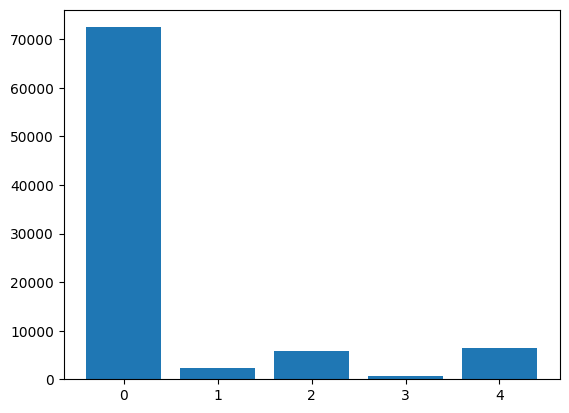

In [8]:
plt.bar(unique,count)

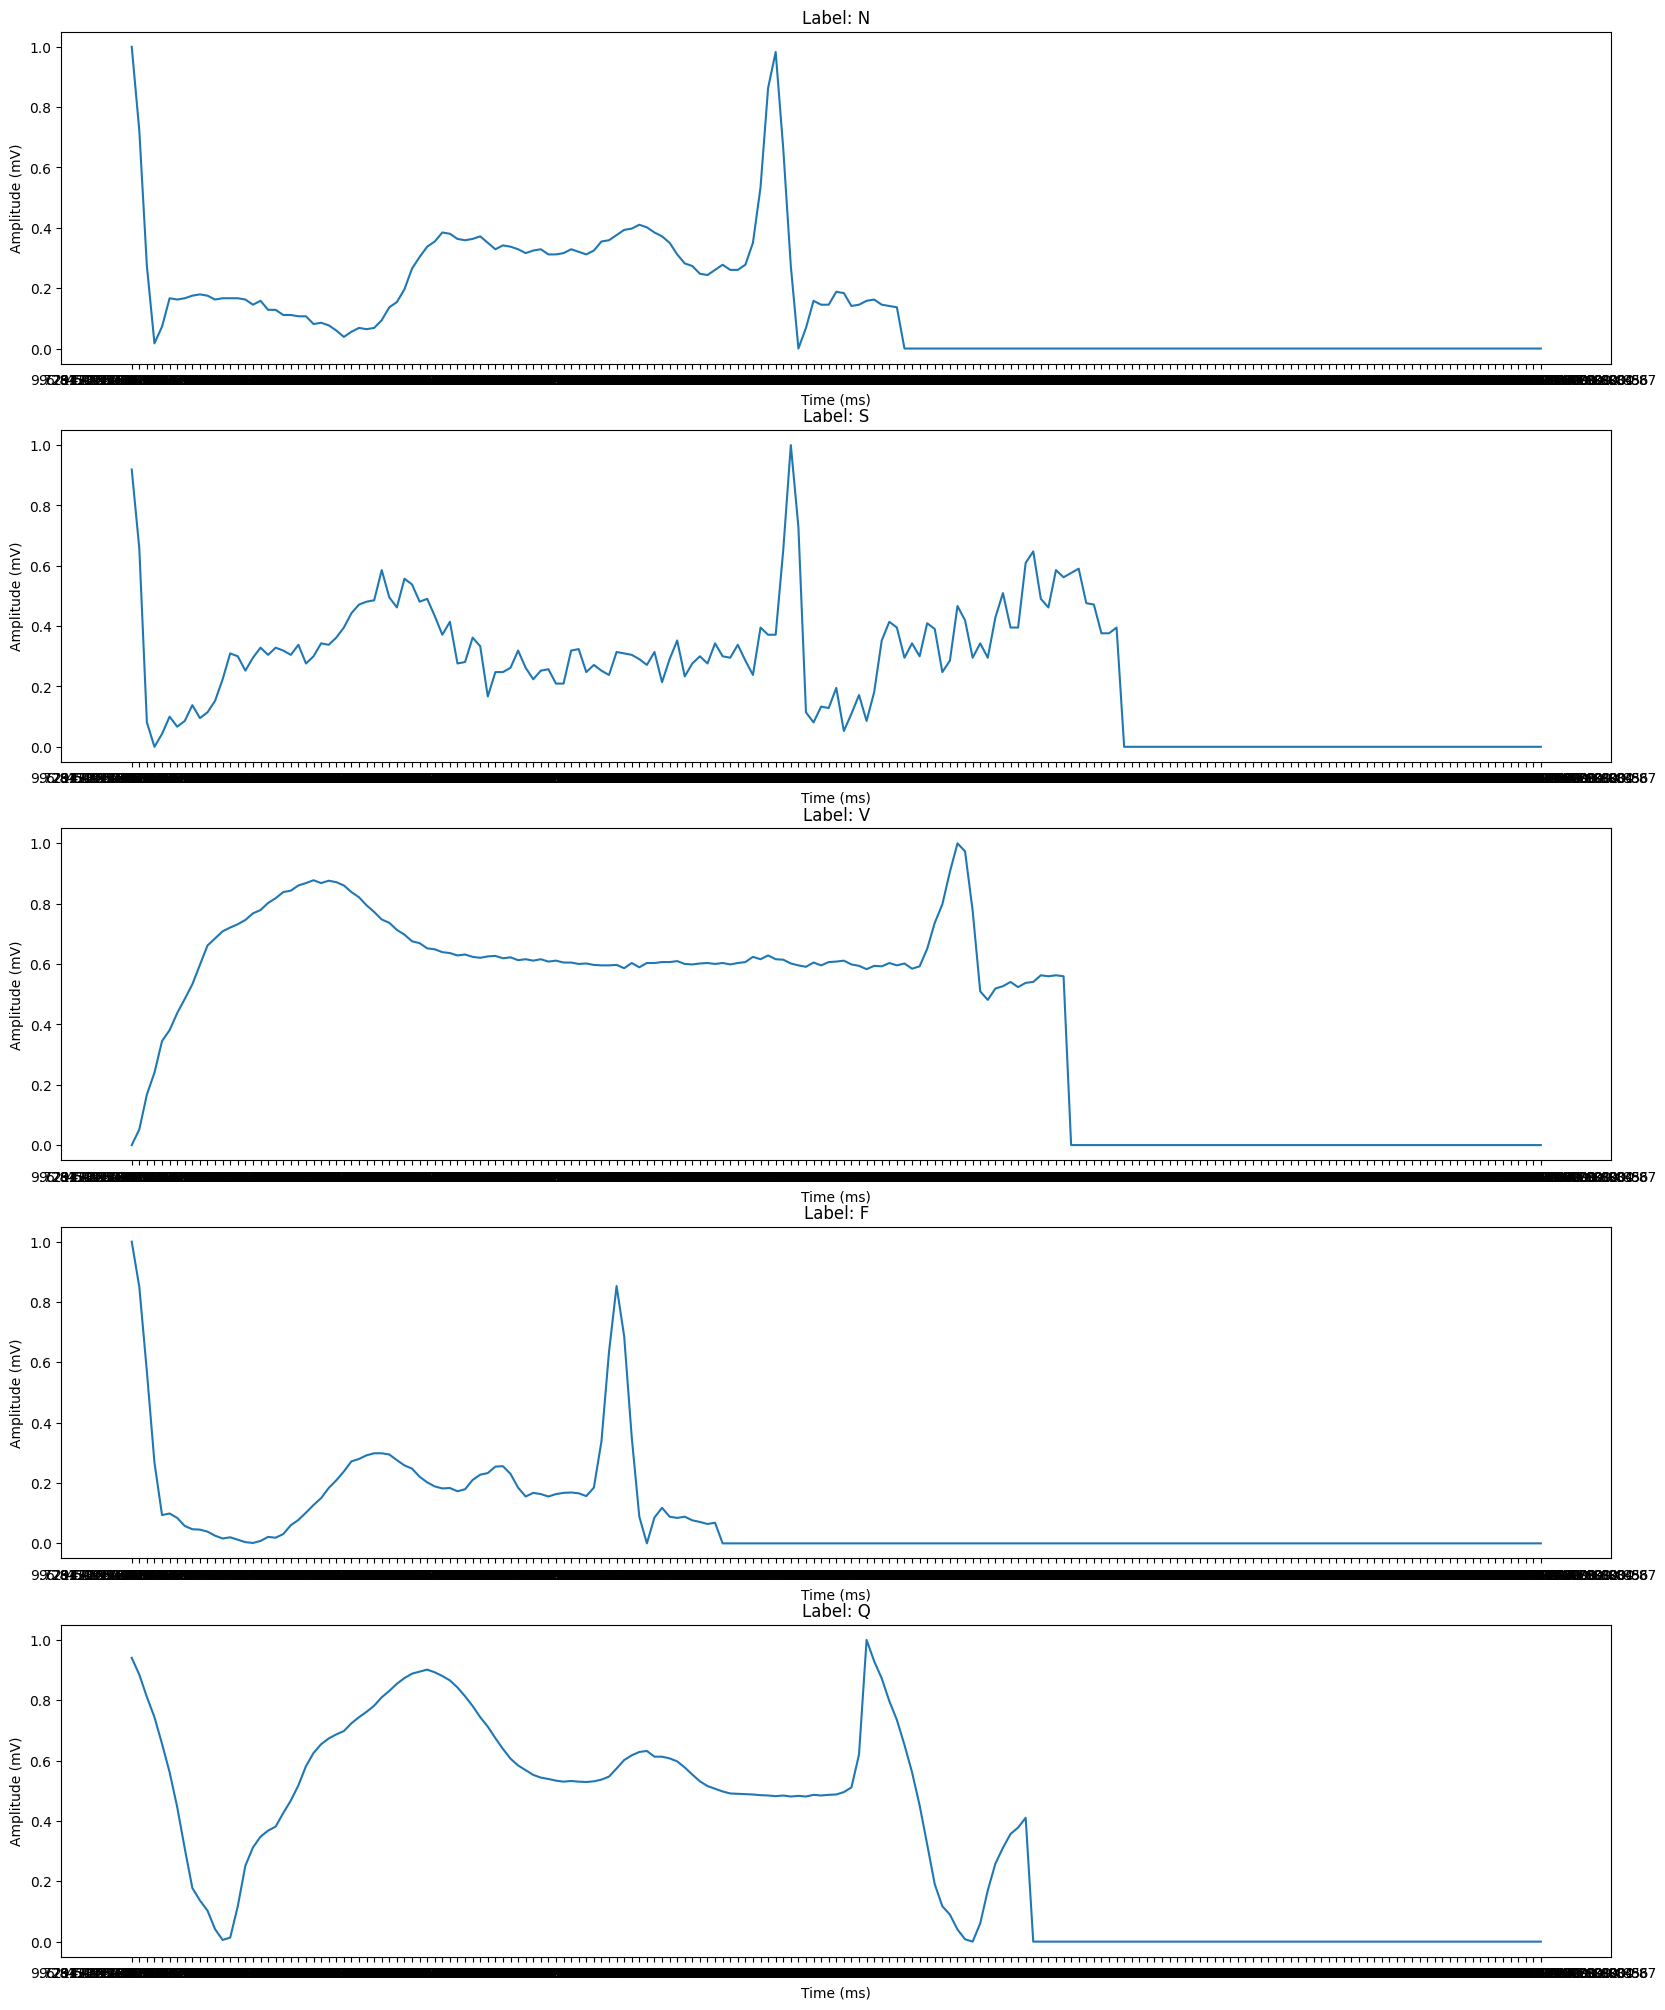

In [10]:
#Preview Class N ECG Shape
fig, ax = plt.subplots(5, 1, figsize=(20, 25))

for i in range(5):
    ax[i].plot(X_df.loc[y_df[y_df == i].sample().index[0]])
    ax[i].set_title(f'Label: {class_names[i]}')
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (mV)')

In [11]:
#Convert to numpy
X_np = X_df.to_numpy()
y_np = y_df.to_numpy()

In [12]:
#Check X_np dimension
X_np.shape

(87553, 187)

In [13]:
#Reshaping X_np
X_np = X_np.reshape(-1, 1, 187)

In [14]:
#Check new dimension of X_np
X_np.shape

(87553, 1, 187)

In [15]:
#Check y_np dimension
y_np.shape

(87553,)

In [16]:
#Reshaping y_np
y_np = y_np.reshape(-1, 1)

In [17]:
#Check new dimension of y_np
y_np.shape

(87553, 1)

In [18]:
print(f'X_np std is {X_np.std()}')

X_np std is 0.22632775223268004


For better model performance, we will be normalizing X_np.

In [19]:
X_mean = X_np.mean()
X_std = X_np.std()
X_max = X_np.max()
X_min = X_np.min()

In [20]:
X_norm = X_np - X_mean
X_norm *= 1/X_std

In [21]:
print(f'X_norm std is {X_norm.std()}')

X_norm std is 0.9999999999999998


Now we start splitting the data and do a bit of augmentation to balance the classes, because as seen from the class distribution graph from before, samples in Class 1 and 3 are signficantly less than 2 and 4.

In [22]:
np.array([[1,2],[3,4],[5,6]]).reshape(-1, 1, 2)

array([[[1, 2]],

       [[3, 4]],

       [[5, 6]]])

### Dataloading

In [23]:
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, train_data_x, train_data_y, transform=None):
        # Whole data as a pandas array
        self.transform = transform
        self.data = np.concatenate((train_data_x, train_data_y.reshape(-1, 1)), axis=1)
        self.dataset_length = len(self.data)
        
        # Extract inputs
        self.input_fetaures_number = 187
        self.input_features = train_data_x.reshape(-1, 1, 187)
        
        # Extract outputs
        self.output_fetaures_number = 1
        self.output_feature = train_data_y
    
    def __getitem__(self, index):
        # Fetch inputs
        x = self.input_features[index]
        if self.transform:
            x = self.transform(x)
        # Fetch outputs
        y = self.output_feature[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

Function used to generate weights required for the WeightedRandomSampler, such that there is an equal probability of each class getting picked

In [24]:
def oversample_weights(signals, nclasses):
    n_images = len(signals)
    _, count_per_class = np.unique(signals[:, -1], return_counts=True)
    
    weight_per_class = [0.] * nclasses
    for i in range(nclasses):
        weight_per_class[i] = float(n_images) / float(count_per_class[i])

    weights = [0] * n_images
    for idx, image_class in enumerate(signals[:, -1]):
        weights[idx] = weight_per_class[int(image_class)]
    return weights

In [25]:
X_mean = train_data.iloc[:, :-1].to_numpy().mean()
X_std = train_data.iloc[:, :-1].to_numpy().std()
y_np = train_data.iloc[:, -1].to_numpy()

X_norm = train_data.iloc[:, :-1].to_numpy() - X_mean
X_norm *= 1/X_std

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_np, test_size=0.2, shuffle=True)

In [27]:
# Train Dataloader
ecg_train_dataset = ECGDataset(X_train, y_train)

train_weights = torch.DoubleTensor(oversample_weights(ecg_train_dataset.data, 5))
train_sampler = torch.utils.data.WeightedRandomSampler(train_weights, len(train_weights))

ECG_train_dataloader = torch.utils.data.DataLoader(ecg_train_dataset, batch_size = 32, sampler=train_sampler)

# Test Dataloader
ecg_test_dataset = ECGDataset(X_test, y_test)

ECG_test_dataloader = torch.utils.data.DataLoader(ecg_test_dataset, batch_size = 32,shuffle=True)

<BarContainer object of 5 artists>

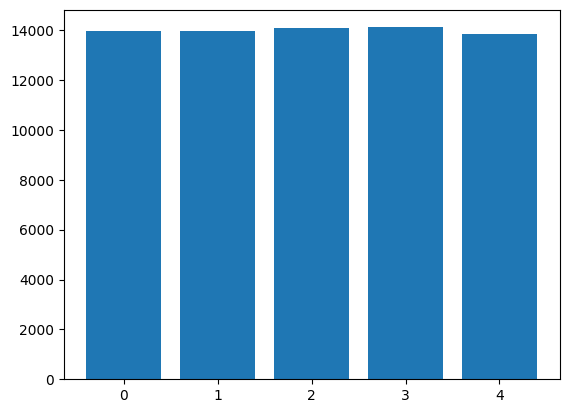

In [28]:
# class counts
counts = [0] * 5
for batch_number, batch in enumerate(ECG_train_dataloader):
    inputs, outputs = batch
    for output in outputs:
        counts[int(output)] += 1
plt.bar([0,1,2,3,4], counts)

### Model

In [29]:
class ConvolutionalBlock(nn.Module):
    def __init__(self, n, ks, pad):
        super(ConvolutionalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n[0], n[1], kernel_size = ks, stride = 1, padding = pad)
        self.batch1 = nn.BatchNorm1d(n[1])
        self.conv2 = nn.Conv1d(n[1], n[2], kernel_size = ks, stride = 1, padding = pad)
        self.conv3 = nn.Conv1d(n[2], n[3], kernel_size = ks, stride = 1, padding = pad)

    def forward(self, x):
        out = self.conv1(x.float())
        out = F.relu(self.batch1(out))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        return out

In [30]:
class ECG_CNN(nn.Module):
    def __init__(self):
        super(ECG_CNN, self).__init__()

        self.blk1 = ConvolutionalBlock([1, 48, 48, 64], ks=11, pad=5)
        self.max1 = nn.MaxPool1d(3, stride=2)
        
        self.blk2 = ConvolutionalBlock([64, 128, 128, 256], 7, 3)
        self.max2 = nn.MaxPool1d(3, stride=2)

        self.blk3 = ConvolutionalBlock([256, 512, 512, 512], 5, 2)
        self.max3 = nn.MaxPool1d(3, stride=2)

        self.blk4 = ConvolutionalBlock([512, 256, 256, 256], 3, 1)
        self.max4 = nn.MaxPool1d(3, stride=2)

        self.drop = nn.Dropout(0.4)

        self.blk5 = ConvolutionalBlock([256, 5, 5, 5], 3, 1)
        self.avg = nn.AdaptiveAvgPool1d(1)

        self.flatten = nn.Flatten()
        

    def forward(self, x):
        
        x = self.max1(self.blk1(x.float()))
        x = self.max2(self.blk2(x))
        x = self.max3(self.blk3(x))
        x = self.max4(self.blk4(x))
        
        x = self.drop(x)

        x = self.avg(self.blk5(x))
        x = self.flatten(x)
        
        return x

#### Trainer Function

In [31]:
def train(model, train_loader, test_loader, epochs = 10, lr = 0.001):
    # Use Adam optimizer to update model weights
    optimizer = optim.Adam(model.parameters(), lr = lr)
    # Use cross-entropy loss function
    criterion = nn.CrossEntropyLoss()
    # Performance curves data
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over training data
        for _, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.float()

            # Zero out gradients
            optimizer.zero_grad()
            # Compute model output and loss
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels.to(torch.int64))
            # Backpropagate loss and update model weights
            loss.backward()
            optimizer.step()
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(train_loader)
        epoch_acc = correct/total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        # Set model to evaluation mode
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels.to(torch.int64))
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
    
    return train_losses, train_accuracies, test_losses, test_accuracies

In [32]:
model = ECG_CNN().to(device)
print(model)

ECG_CNN(
  (blk1): ConvolutionalBlock(
    (conv1): Conv1d(1, 48, kernel_size=(11,), stride=(1,), padding=(5,))
    (batch1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(48, 48, kernel_size=(11,), stride=(1,), padding=(5,))
    (conv3): Conv1d(48, 64, kernel_size=(11,), stride=(1,), padding=(5,))
  )
  (max1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blk2): ConvolutionalBlock(
    (conv1): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (batch1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (conv3): Conv1d(128, 256, kernel_size=(7,), stride=(1,), padding=(3,))
  )
  (max2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blk3): ConvolutionalBlock(
    (conv1): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (batch1): 

In [33]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     ECG_train_dataloader, \
                                                                     ECG_test_dataloader, \
                                                                     epochs = 50, \
                                                                     lr = 0.001)

--- Epoch 1/50: Train loss: 0.5550, Train accuracy: 0.8007
--- Epoch 1/50: Test loss: 0.3226, Test accuracy: 0.9097
--- Epoch 2/50: Train loss: 0.2435, Train accuracy: 0.9157
--- Epoch 2/50: Test loss: 0.4332, Test accuracy: 0.8691
--- Epoch 3/50: Train loss: 0.1722, Train accuracy: 0.9420
--- Epoch 3/50: Test loss: 0.3100, Test accuracy: 0.8962
--- Epoch 4/50: Train loss: 0.1290, Train accuracy: 0.9582
--- Epoch 4/50: Test loss: 0.2125, Test accuracy: 0.9291
--- Epoch 5/50: Train loss: 0.0989, Train accuracy: 0.9684
--- Epoch 5/50: Test loss: 0.1895, Test accuracy: 0.9391
--- Epoch 6/50: Train loss: 0.0819, Train accuracy: 0.9738
--- Epoch 6/50: Test loss: 0.1387, Test accuracy: 0.9562
--- Epoch 7/50: Train loss: 0.0703, Train accuracy: 0.9786
--- Epoch 7/50: Test loss: 0.2350, Test accuracy: 0.9315
--- Epoch 8/50: Train loss: 0.0612, Train accuracy: 0.9810
--- Epoch 8/50: Test loss: 0.1088, Test accuracy: 0.9686
--- Epoch 9/50: Train loss: 0.0545, Train accuracy: 0.9829
--- Epoch 9/5

### Loss Graphs and Evaluation

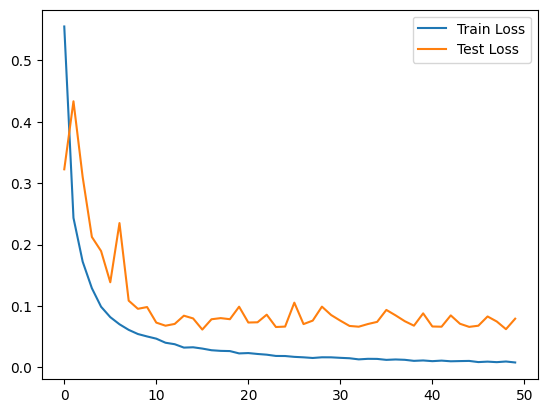

In [34]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()

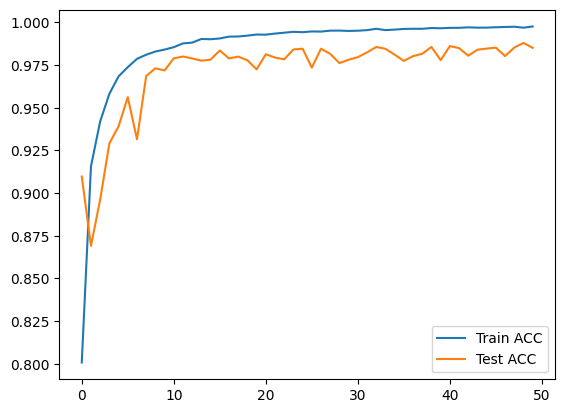

In [35]:
plt.plot(train_accuracies, label="Train ACC")
plt.plot(test_accuracies, label="Test ACC")
plt.legend()

In [36]:
correct = 0
total = 0
for inputs, labels in ECG_test_dataloader:

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct/total}")

Test Accuracy: 0.9850950830906288


### SAVE AND LOAD

In [37]:
# Saving Weights
torch.save(model.state_dict(), "model_weights.pth")

To load the pretrained weights, run the <b>Imports and Initialization</b>, <b>Dataloading</b>, and <b>Model</b> sections up to the trainer function, then run the cells below

In [38]:
# Load New Model
test_model = ECG_CNN().to(device)
test_model.load_state_dict(torch.load('model_weights.pth'))
test_model.eval()

ECG_CNN(
  (blk1): ConvolutionalBlock(
    (conv1): Conv1d(1, 48, kernel_size=(11,), stride=(1,), padding=(5,))
    (batch1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(48, 48, kernel_size=(11,), stride=(1,), padding=(5,))
    (conv3): Conv1d(48, 64, kernel_size=(11,), stride=(1,), padding=(5,))
  )
  (max1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blk2): ConvolutionalBlock(
    (conv1): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (batch1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (conv3): Conv1d(128, 256, kernel_size=(7,), stride=(1,), padding=(3,))
  )
  (max2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (blk3): ConvolutionalBlock(
    (conv1): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (batch1): 

### Evaluation

In [39]:
#Confusion matrix generation function
def plot_cm(model, dl, categories, normalize='true'):
    #plot the confusion matrix
    model.eval()
    y_pred = []
    y_true = []
    for x, y in dl:
        x = x.to(device)
        y = y.to(device)
        output = model(x) #out shape: (batch_size, 5)
        y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())
        y_true.extend(y.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    sns.heatmap(cm, annot=True, fmt= '.2f', cmap='Blues', xticklabels=categories.values(), yticklabels=categories.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print(classification_report(y_true, y_pred, target_names=class_names.values()))

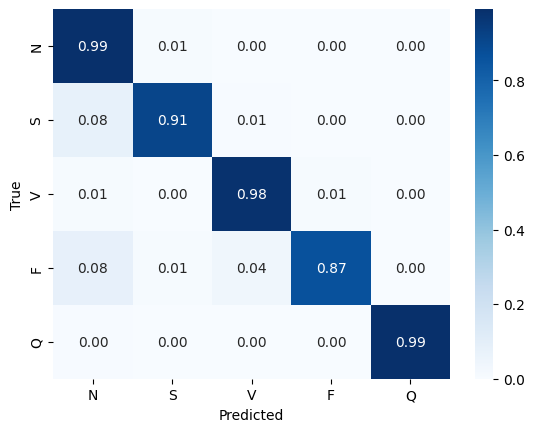

              precision    recall  f1-score   support

           N       1.00      0.99      0.99     14487
           S       0.77      0.91      0.84       434
           V       0.96      0.98      0.97      1161
           F       0.82      0.87      0.84       119
           Q       0.99      0.99      0.99      1310

    accuracy                           0.99     17511
   macro avg       0.91      0.95      0.93     17511
weighted avg       0.99      0.99      0.99     17511



In [40]:
plot_cm(test_model, ECG_test_dataloader, class_names)

True: N 	 Predicted: V


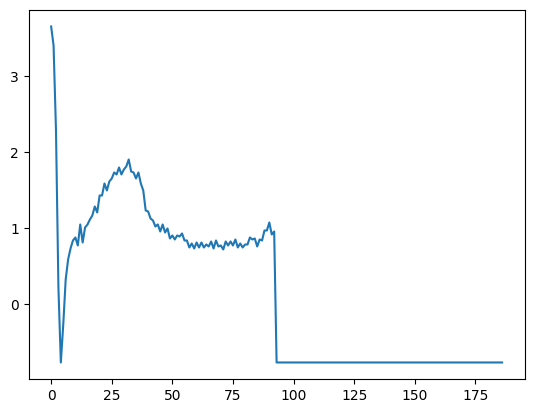

True: F 	 Predicted: V


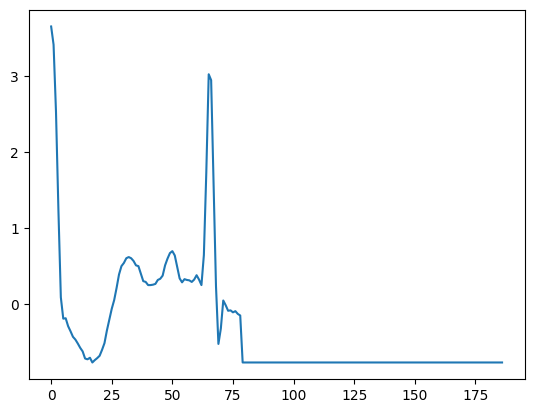

True: S 	 Predicted: V


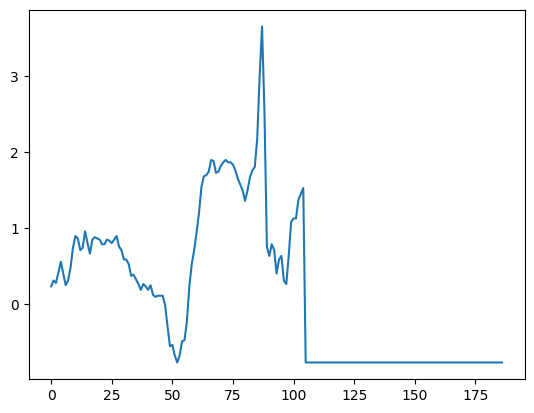

True: S 	 Predicted: N


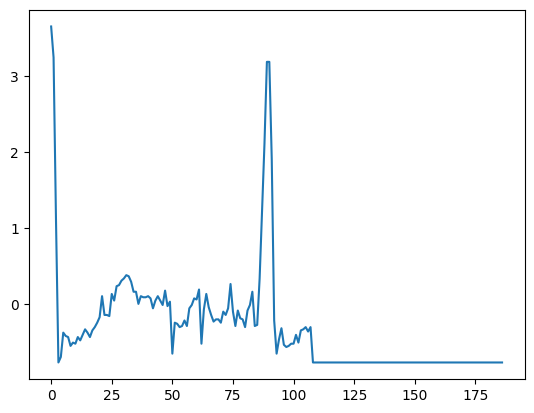

True: N 	 Predicted: S


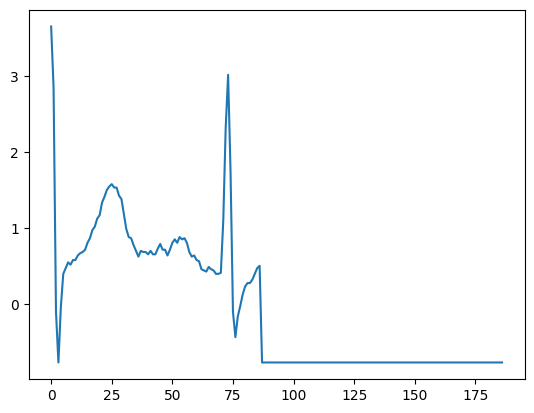

In [41]:
#Erroneous predictions
test_model.eval()
count = 0
for x, y in ECG_test_dataloader:
    x = x.to(device)
    y = y.to(device)
    output = test_model(x)
    y_pred = torch.argmax(output, dim=1)
    for i in range(len(y_pred)):
        if y_pred[i] != y[i] and count < 5:
            print(f'True: {class_names[y[i].item()]} \t Predicted: {class_names[y_pred[i].item()]}')
            plt.plot(x[i, 0, :].cpu().numpy())
            plt.show()
            count += 1